#Import Relevant Libraries


In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config;
set_config(display='diagram')

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

from xgboost import XGBRegressor

#Import Dataset from Kaggle

In [11]:
!pip install kaggle

In [12]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
# Upload your own API Token from kaggle in Colab before running this cell
!cp kaggle.json ~/.kaggle/

In [14]:
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle competitions download -c 'house-prices-advanced-regression-techniques'

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 85.4MB/s]


In [16]:
! mkdir data

mkdir: cannot create directory ‘data’: File exists


In [17]:
! unzip house-prices-advanced-regression-techniques.zip -d data

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data/data_description.txt  
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


# Import Data

In [18]:
url = "data"
data = pd.read_csv(f'{url}/train.csv', index_col="Id")

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.shape

In [20]:
# Split Features/Target

X = data.drop(columns='SalePrice')
y = data['SalePrice']

X.shape, y.shape

((1460, 79), (1460,))

# Baseline Model

### EDA

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [22]:
# Number of Unique Categories

feat_categorical_nunique = X.select_dtypes(include='object').nunique()

pd.DataFrame(feat_categorical_nunique).T

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6


In [23]:
feat_categorical_nunique.sum()

252

<Axes: ylabel='Frequency'>

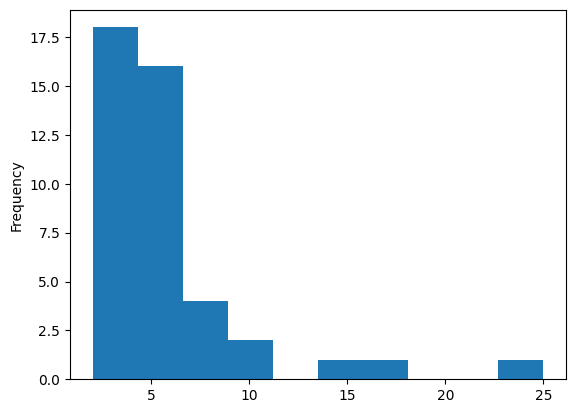

In [24]:
feat_categorical_nunique.plot.hist()

In [25]:
# Number of Categories with Less than 7 Unique Values

feat_categorical_small = list(pd.DataFrame(feat_categorical_nunique[feat_categorical_nunique < 7]).index)
len(feat_categorical_small)

34

### Pipeline

#### Preprocessing


The **num_transformer** pipeline handles numerical columns. It applies two steps sequentially: *SimpleImputer* with the strategy set to "mean" and *MinMaxScaler* for scaling the features.

The **cat_transformer** pipeline handles categorical columns. It also applies two steps sequentially: *SimpleImputer* with the strategy set to "most_frequent" and *OneHotEncoder* with the handle_unknown parameter set to 'ignore' to handle unknown categories.

The **make_column_transformer** function combines the two transformers, num_transformer and cat_transformer, and specifies which columns they should be applied to.
- *num_col* is a selector that filters columns based on their data type, including only columns with data types 'float64' and 'int64'.
- *feat_categorical_small* is expected to be a list of column names representing the categorical features to be transformed.
-*remainder="drop"* parameter ensures that any columns not selected for transformation are dropped from the output.

Overall, the preproc_baseline pipeline applies the appropriate preprocessing steps to both numerical and categorical columns, using the specified strategies for handling missing values and scaling the numerical features, as well as one-hot encoding the categorical features.

In [26]:
## Preprocess the Pipeline

# Numerical transformer
num_transformer = make_pipeline(SimpleImputer(strategy="mean"),
                                MinMaxScaler())

# Categorical transformer
cat_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OneHotEncoder(handle_unknown='ignore'))

# Define column selectors
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# Column transformer
preproc_baseline = make_column_transformer((num_transformer, num_col),
                                           (cat_transformer, feat_categorical_small),
                                           remainder="drop"
                                           )

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [27]:
pd.DataFrame(preproc_baseline.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
# The shape has 183 columns as One-Hot Encoding results in creating one column per unique value in the categorical feature

shape_preproc_baseline = pd.DataFrame(preproc_baseline.fit_transform(X)).shape
shape_preproc_baseline

(1460, 183)

#### Regressor

In [29]:
# Adding a Model

model = DecisionTreeRegressor()

pipe_baseline = make_pipeline(preproc_baseline, model)
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

#### Cross Validation

In [30]:
# This is our metric to minimize
def func_rmsle(y_pred, y):

    return np.sqrt(np.square(np.log(y + 1) - np.log(y_pred + 1)).mean())

# This is our score to maximize
def func_rmsle_neg(y_pred, y):

    return np.sqrt(np.square(np.log(y + 1) - np.log(y_pred + 1)).mean())*(-1)

In [31]:
rmsle =  make_scorer(func_rmsle)
rmsle

make_scorer(func_rmsle)

In [32]:
rmsle_neg = make_scorer(func_rmsle_neg)
rmsle_neg

make_scorer(func_rmsle_neg)

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [33]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.20873501180823145

#### Prediction

In [47]:
# Import test set

data_test = pd.read_csv(f'{url}/test.csv')

data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [48]:
# Keep ids for reference
X_test_ids = data_test['Id']

# Remove 'Id' column from test data
X_test = data_test.drop(columns=['Id'])

# Predict y_pred_baseline using the fitted pipeline
y_pred_baseline = pipe_baseline.predict(X_test)

# Print or use y_pred_baseline for further analysis
y_pred_baseline


array([129000., 157900., 193000., ..., 139000.,  93500., 200000.])

In [49]:
# Create DataFrame with the results

results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(3)

,Id,SalePrice
0,1461,129000.0
1,1462,157900.0
2,1463,193000.0


In [50]:
# Export to Kaggle format submission in the `data` folder

results.to_csv("data/submission_baseline.csv", header=True, index=False)

#### GridSearch

In [53]:
# Get Parameters for GridSearch

pipe = Pipeline([('preprocessing', preproc_baseline),
                 ('model', model)
                 ])

pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [59]:
# Split the data into features (X) and target variable (y)
X = data.drop(columns='SalePrice')
y = data['SalePrice']

# Create GridSearchCV object
search = GridSearchCV(pipe,
                      param_grid={'model__min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                  'model__min_samples_split': [2, 4, 6, 8, 10]},
                      cv=5,
                      scoring=rmsle,
                      n_jobs=-1)

# Fit the grid search on the data
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_f...
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('model', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'model__min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'model__min_samples_split': [2, 4, 6, 8, 10]},
             scoring=make_scorer(func_rmsle))

In [60]:
# Get Best Score

search.best_score_

0.21007557583298078

# Other Models

## Random Forest Regressor

In [62]:
# Get Parameters for GridSearch

model2 = RandomForestRegressor()

pipe2 = Pipeline([
                  ('preprocessing', preproc_baseline),
                  ('model', model2)
                  ])

pipe2.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [65]:
# Create Params Grid
param_grid = {'model__min_samples_leaf': [1, 2, 3],
              'model__min_samples_split': [2, 3, 4],
              'model__n_estimators': [100]}

# Create GridSearchCV object
rf_search = GridSearchCV(pipe2,
                       param_grid=param_grid,
                       cv=5,
                       scoring=rmsle,
                       n_jobs=-1)

# Fit the grid search on the data
rf_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_f...
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__min_samples_leaf': [1, 2, 3],
                         'model__min_samples_split': [2, 3, 4],
                         'model__n_estimators': [100]},
             scoring=make_scorer(func_rmsle))

In [66]:
# Get Best Score

rf_search.best_score_

0.14823521824235023

In [67]:
random_forest_params = rf_search.best_estimator_
random_forest_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4ad8ea40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('model', RandomForestRegressor(min_samples_leaf=3))])

## Gradient Boosting Regressor

In [70]:
# Get Parameters for GridSearch

model3 = GradientBoostingRegressor()

pipe3 = Pipeline([
                  ('preprocessing', preproc_baseline),
                  ('model', model3)
                  ])

pipe3.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [71]:
# Create Params Grid
param_grid={'model__max_depth': [3,4],
                                'model__learning_rate': [0.1,0.2],
                                'model__n_estimators': [100]}

# Create GridSearchCV object
gb_search = GridSearchCV(pipe3,
                         param_grid=param_grid,
                         cv=5,
                         scoring=rmsle,
                         n_jobs=-1)

# Fit the grid search on the data
gb_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_f...
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.2],
                         'model__max_depth': [3, 4],
                         'model__n_estimators': [100]},
             scoring=make_scorer(func_rmsle))

In [72]:
# Get Best Score

gb_search.best_score_

0.13423901488682585

In [73]:
gradient_boosting_params = gb_search.best_estimator_
gradient_boosting_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4ac7ad70>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('model', GradientBoostingRegressor(learning_rate=0.2))])

## XGB Regressor

In [75]:
# Get Parameters for GridSearch

xgb_reg = XGBRegressor()

pipe4 = Pipeline([
                  ('preprocessing', preproc_baseline),
                  ('model', xgb_reg)
                  ])

pipe4.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [76]:
# Create Params Grid
param_grid={'model__max_depth': [3,4],
            'model__learning_rate': [0.1,0.2],
            'model__n_estimators': [100]}

# Create GridSearchCV object
xb_search = GridSearchCV(pipe4,
                         param_grid=param_grid,
                         cv=5,
                         scoring=rmsle,
                         n_jobs=-1)

# Fit the grid search on the data
xb_search.fit(X,y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_f...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.2],
                         'model__max_depth': [3, 4],
                         'model__n_estimators': [100]},
             scoring=make_scorer(func_rmsle))

In [77]:
# Get Best Score

xb_search.best_score_

0.13462077599201672

In [78]:
xg_boosting_params = xb_search.best_estimator_
xg_boosting_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4990d780>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

## Stacking Regressor

In [82]:
# Define the ensemble of models
ensemble = StackingRegressor(
                              estimators=[
                                  ("rf", RandomForestRegressor(min_samples_leaf=2, min_samples_split=2)),
                                  ("gr", GradientBoostingRegressor(learning_rate=0.2))
                              ],
                              final_estimator=XGBRegressor(
                                  base_score=0.5, booster='gbtree', callbacks=None,
                                  colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                                  early_stopping_rounds=None, enable_categorical=False,
                                  eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                                  importance_type=None, interaction_constraints='',
                                  learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
                                  max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
                                  monotone_constraints='()', n_estimators=100, n_jobs=0,
                                  num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
                                  reg_lambda=1
                              )
                          )

# Create the pipeline
pipe5 = Pipeline([
                ('preprocessing', preproc_baseline),
                ('model', ensemble)
                ])


In [83]:
# Cross Validate

score_baseline_stacking = cross_val_score(pipe5, X, y, cv=5, scoring= rmsle).mean()
score_baseline_stacking

0.1403231597295455

In [84]:
pipe5

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb4d327310>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                                feature_types=None,
                                                                gamma=0,
                                                                gpu_id=-1,
                                                                grow_policy='depthwise',
                                                                importance_type=None,
                                                                interaction_constraints='',
                                                                learning_rate=0.1,
                                                                max_bin=256,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=4,
                                                                max_delta_step=0,
                                                                max_depth=4,
                                                                max_leaves=0,
                                                                min_child_weight=1,
                                                                missing=nan,
                                                                monotone_constraints='()',
                                                                n_estimators=100,
                                                                n_jobs=0,
                                                                num_parallel_tree=1,
                                                                predictor='auto',
                                                                random_state=0, ...)))])

# Best Model

In [86]:
best_score = xb_search.best_score_
best_score

0.13462077599201672

In [87]:
# Prediction

y_pred_baseline_final = xg_boosting_params.predict(data_test)
y_pred_baseline_final

array([124291.26, 162739.53, 177460.55, ..., 166953.23, 121080.89,
       229175.55], dtype=float32)

In [90]:
# Create DataFrame with the results

final_result = pd.concat([X_test_ids, pd.Series(y_pred_baseline_final, name="SalePrice")], axis=1)
final_result.head(3)

,Id,SalePrice
0,1461,124291.257812
1,1462,162739.531250
2,1463,177460.546875


In [91]:
# Export to Kaggle format submission in the `data` folder

final_result.to_csv("data/submission_final.csv", header=True, index=False)